In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import sys
sys.path.append('c:/Users/tomas/Documents/Programación/Github/Patricionog/Modulio/Readmes')
import Appio as ap
import Archivio as ac
import Databasio as bd
import Datetimio as dt
import Dictio as dc
import Excelio as ex
import Footio as ft
import Foragio as fg
import Framio as fr
import Graphio as gr
import Highlightio as hg
import Inputio as ip
import Listio as ls
import Mathio as mt
import Notio as nt
import Numbio as nb
import Numpio as nm
import Stringio as st
import Timio as tm
import Tkintio as tn
import Toolio as to

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.diagnostic import linear_harvey_collier
from scipy import stats

Los métodos robustos disminuyen el grado en que los resultados pueden verse influenciados por violaciones de los supuestos estadísticos clásicos.

In [12]:
# Cargar df.
df = pd.read_excel('J:/My Drive/Experimento/Plantillas finales/3. Ballotage - Filtrado (sin outliers).xlsx')  

In [13]:
# Definir variables.
Variables_Independientes = ['genero',
            'edad',
            #'nacionalidad',
            #'provincia',
            #'e_social',
            #'niv_educativo',
            'voto_2019',
            #'voto_PASO_2023',
            #'candidato_PASO_2023',
            'autopercep_izqder',
            'autopercep_conpro',
            'autopercep_perantiper',
            'indice_positividad',
            #'massa_ip_izqder',
            #'massa_ip_conpro',
            #'bullrich_ip_izqder',
            #'bullrich_ip_conpro',
            #'schiaretti_ip_izqder',
            #'schiaretti_ip_conpro',
            #'milei_ip_izqder',
            #'milei_ip_conpro',
            #'bregman_ip_izqder',
            #'bregman_ip_conpro',
            'indice_progresismo',
            'indice_conservadurismo'
            ]
Variables_Dependientes = ['cambio_op_con', 'cambio_op_pro', 
                          'cambio_op_con_izq', 'cambio_op_con_der', 'cambio_op_pro_izq', 'cambio_op_pro_der',]

In [14]:
# Rellenar valores NaN con 0 para todo el DataFrame.
df.fillna(0, inplace=True)

In [15]:
# Cortar df.
df = df[Variables_Dependientes + Variables_Independientes]

In [16]:
for Column in Variables_Independientes:
    if df[Column].dtype == 'object':
        df = fr.Create_Dummy_Variables(df, Column, Drop_First = False, Group_Others = True, Remove_Others = False, 
                                    Threshold = 0.05, Name_Other_Column = f"{Column}_Others", Name_Columns_Style = None, Separator=None)

In [17]:
# Object to numeric df.
def Convert_Object_Columns_In_Numerics(df):
    # Convertir columnas booleanas a numéricas (0 y 1).
    for Column in df.columns:
        if df[Column].dtype == 'bool':
            df[Column] = df[Column].astype(int)
    
    return df

df = Convert_Object_Columns_In_Numerics(df)

In [18]:
# Redefinir las variables independientes.
Variables_Independientes = [Column for Column in df.columns if Column not in Variables_Dependientes]
Variables_Independientes.remove('genero_Others')
Variables_Independientes.remove('genero_masculino')
Variables_Independientes.remove('voto_2019_Others')
Variables_Independientes.remove('voto_2019_no vote')
Variables_Independientes.remove('voto_2019_Nicolás Del Caño')

In [19]:
# Generate a list of variables with p-value less than 0.05.
def Generalized_Regression(df, V_Ind, V_Dep, Summary = False):

    # Definir la variable dependiente y las independientes.
    Y = df[V_Dep]
    X = df[V_Ind]  

    # Añadir constante para el término independiente.
    X = sm.add_constant(X)

    # Ajustar el modelo de regresión generalizada con una familia Gaussiana.
    Model = sm.GLM(Y, X, family=sm.families.Gaussian())
    Results = Model.fit()

    # Imprimir resultados.
    if Summary:
        print(Results.summary())

    # Generate a list of variables with p-value less than 0.05.
    Significant_Variables = Results.pvalues[Results.pvalues < 0.05].index.tolist()

    return Significant_Variables

In [20]:
def Check_GLM_Assumptions(DataFrame: pd.DataFrame, V_Ind: list, V_Dep: list):

    """Check the assumptions of Generalized Linear Model (GLM) and print test results."""
    
    Y = DataFrame[V_Dep]
    X = DataFrame[V_Ind]
    
    X = sm.add_constant(X)
    Model = sm.GLM(Y, X, family=sm.families.Binomial()).fit()
    Residuals = Model.resid_deviance
    
    # 1. Linearity of logit
    plt.figure(figsize=(12, 6))

    # Check linearity with respect to continuous predictors
    for Column in X.columns[1:]:  # Skip constant
        sns.regplot(x=X[Column], y=Residuals, lowess=True, line_kws={'color': 'red'})
        plt.title(f'Linearity Check: {Column} vs Residuals')
        plt.xlabel(Column)
        plt.ylabel('Deviance Residuals')
        plt.show()

    # 2. Multicollinearity
    VIF_Data = pd.DataFrame()
    VIF_Data["Feature"] = X.columns
    VIF_Data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    print("\nVariance Inflation Factor (VIF) for Multicollinearity:")
    print(VIF_Data.to_string(index=False))

    # 3. Goodness of Fit - Deviance Test
    print("\nModel Summary:")
    print(Model.summary())

    # 4. Residuals distribution
    plt.figure(figsize=(12, 6))
    
    # Deviance Residuals distribution
    sns.histplot(Residuals, kde=True)
    plt.title('Deviance Residuals Distribution')
    plt.xlabel('Deviance Residuals')
    plt.show()

    # 5. Hosmer-Lemeshow Goodness of Fit Test (for binary GLM)
    # Crear un decil para comparar el modelo predicho con la variable dependiente.
    Groups = pd.qcut(Model.predict(), 10, duplicates='drop')
    Contingency_Table = pd.crosstab(Groups, Y.squeeze())

    # Realizar la prueba de bondad de ajuste Hosmer-Lemeshow.
    H1_Test = sm.stats.diagnostic.linear_harvey_collier(Model, skip=5)

    print("\nHosmer-Lemeshow Test for Goodness of Fit:")
    print(f"Test Statistic: {H1_Test.statistic}, p-value: {H1_Test.pvalue}")

----------------------------------------------------------------
Variable dependiente: cambio_op_con.
----------------------------------------------------------------
Variables significativas:
Variable: indice_progresismo


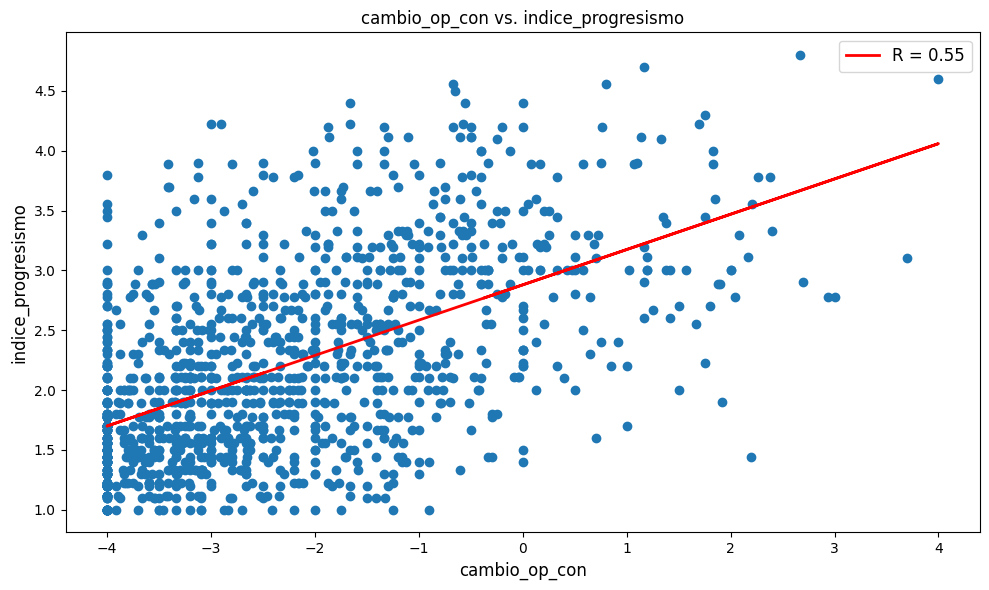

Variable: indice_conservadurismo


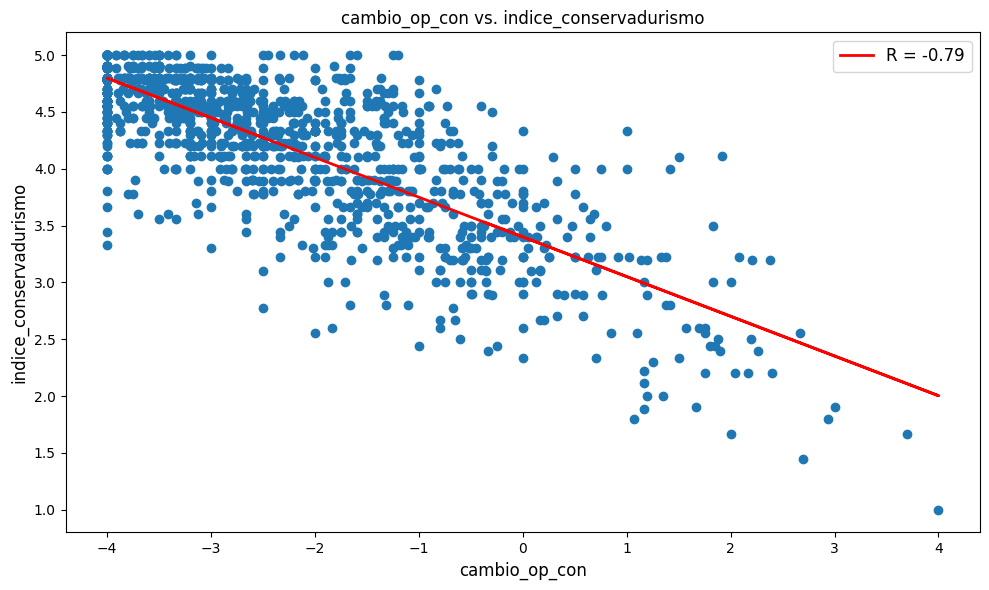

----------------------------------------------------------------
Variable dependiente: cambio_op_pro.
----------------------------------------------------------------
Variables significativas:
Variable: indice_progresismo


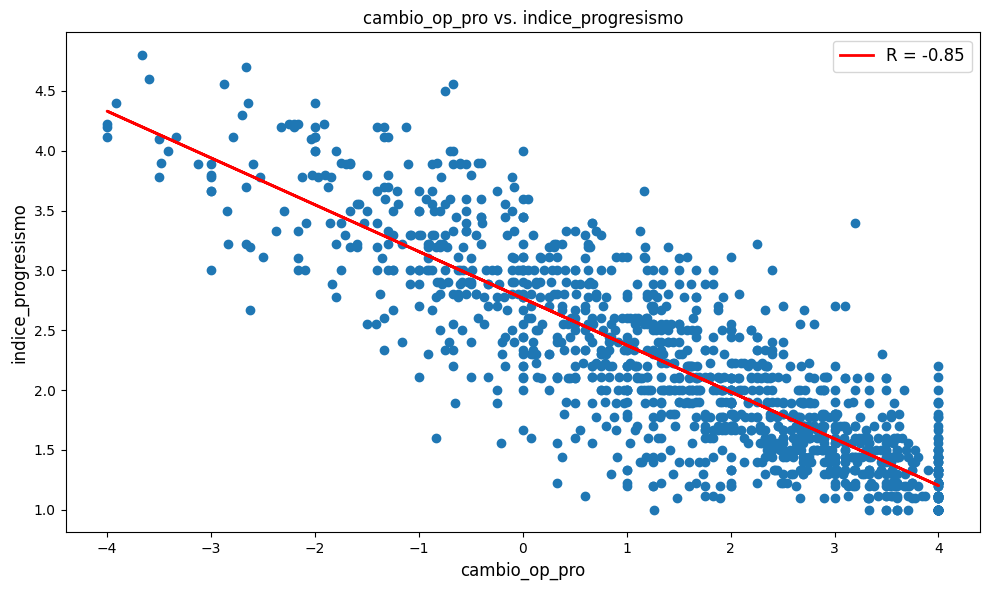

----------------------------------------------------------------
Variable dependiente: cambio_op_con_izq.
----------------------------------------------------------------
Variables significativas:
Variable: indice_conservadurismo


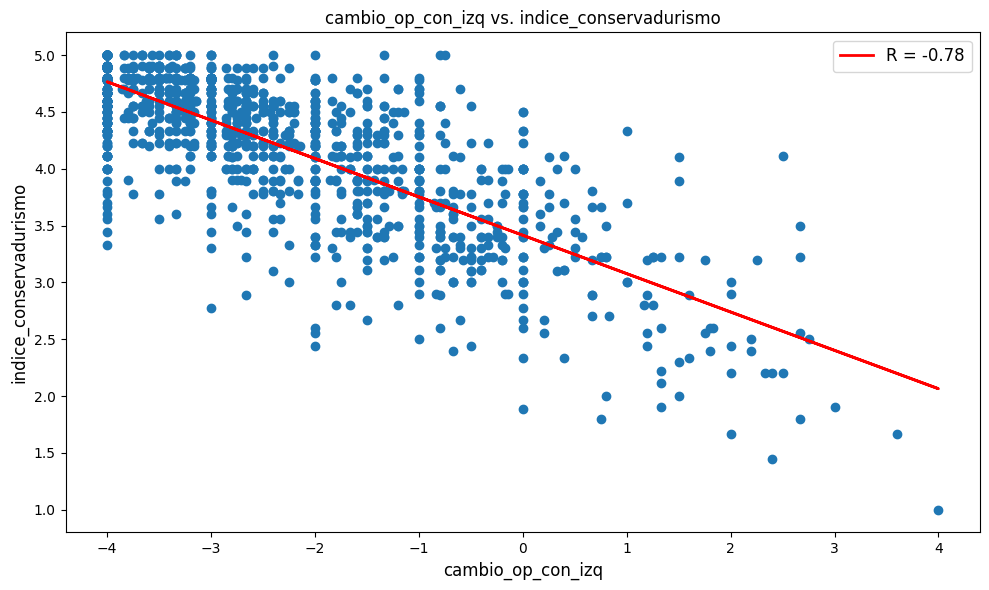

----------------------------------------------------------------
Variable dependiente: cambio_op_con_der.
----------------------------------------------------------------
Variables significativas:
Variable: indice_progresismo


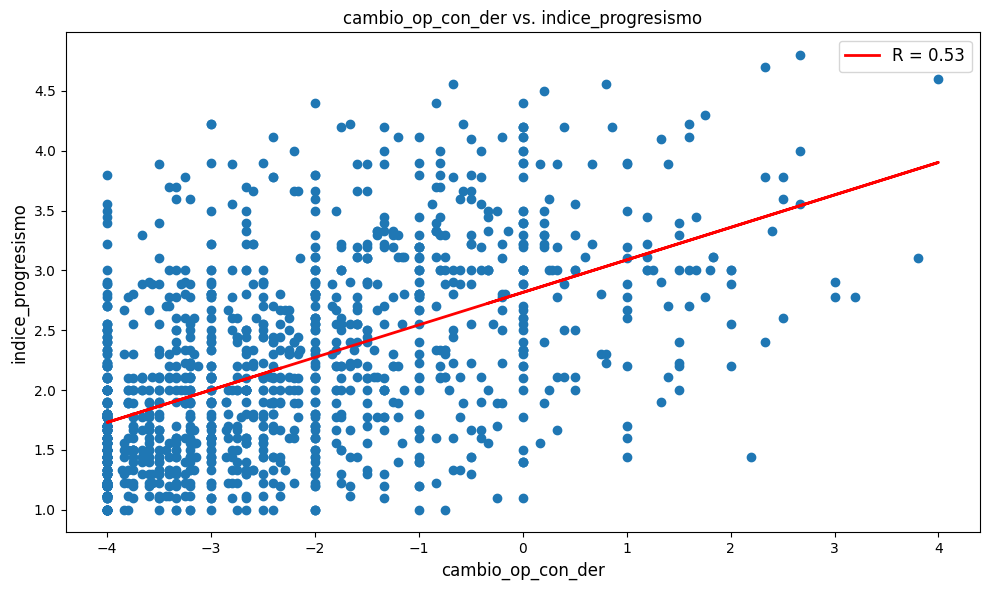

Variable: indice_conservadurismo


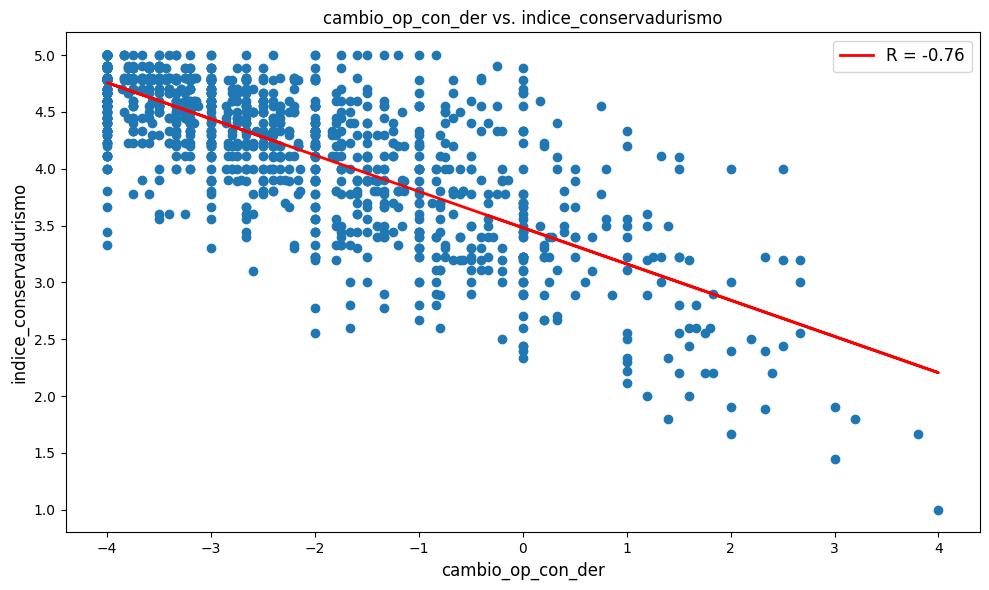

----------------------------------------------------------------
Variable dependiente: cambio_op_pro_izq.
----------------------------------------------------------------
Variables significativas:
Variable: indice_progresismo


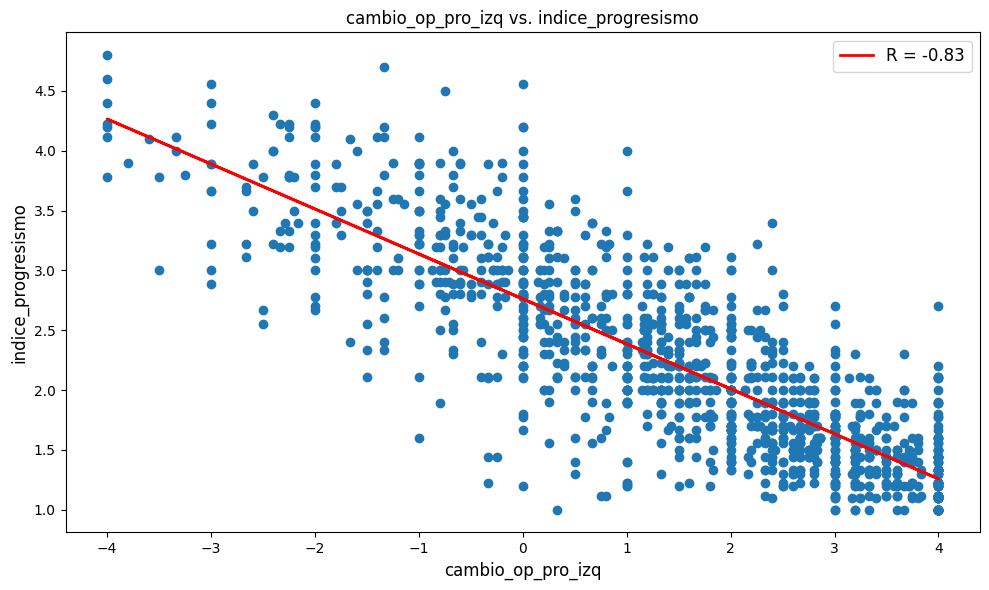

----------------------------------------------------------------
Variable dependiente: cambio_op_pro_der.
----------------------------------------------------------------
Variables significativas:
Variable: edad


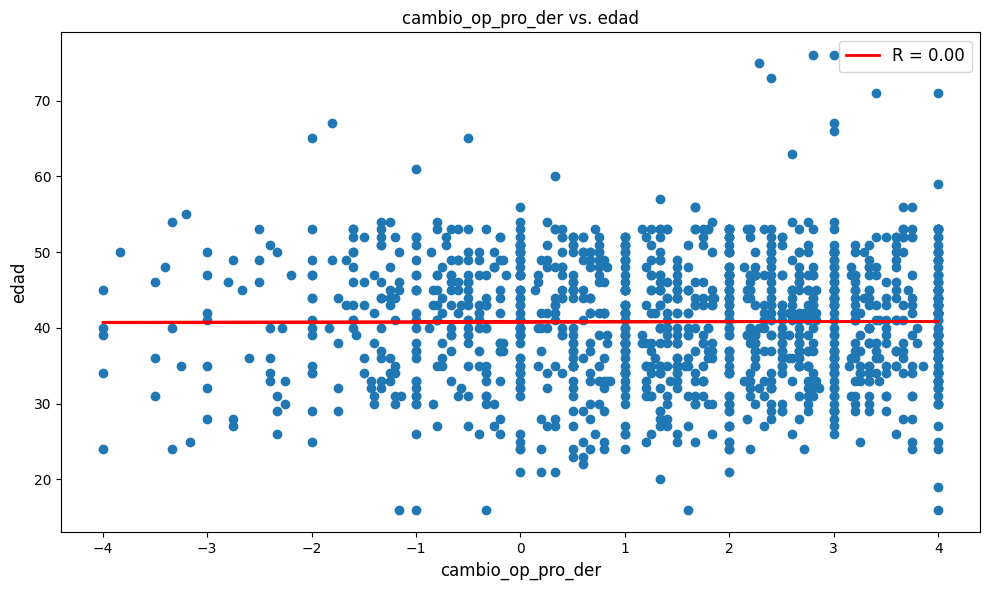

Variable: indice_progresismo


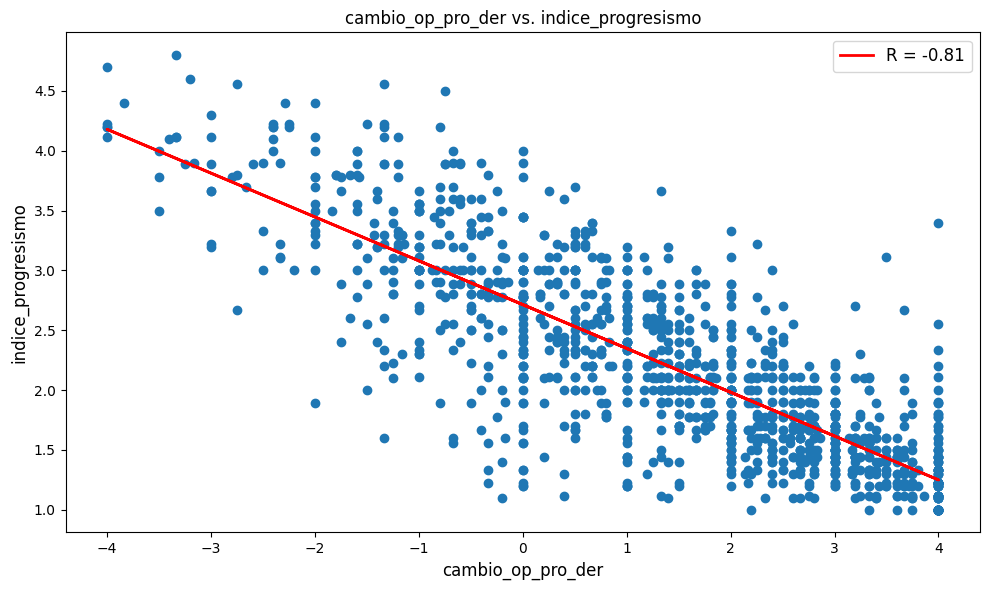

In [21]:
for Variable_Dependiente in Variables_Dependientes:

    V_Dependientes_Para_Comparar = Variables_Independientes

    print('----------------------------------------------------------------')
    print(f'Variable dependiente: {Variable_Dependiente}.')
    print('----------------------------------------------------------------')

    Significativas = Generalized_Regression(df, Variables_Independientes, Variable_Dependiente)

    if 'const' in Significativas:
        Significativas.remove('const')

    #Check_GLM_Assumptions(df, V_Dependientes_Para_Comparar, Variable_Dependiente)

    while sorted(Significativas) != sorted(V_Dependientes_Para_Comparar):
        V_Dependientes_Para_Comparar = Significativas
        Significativas = Generalized_Regression(df, V_Dependientes_Para_Comparar, Variable_Dependiente)

        if 'const' in Significativas:
            Significativas.remove('const')

    print(f'Variables significativas:')
    for Variable in Significativas:
        print(f'Variable: {Variable}')
        if sorted(list(df[Variable].unique())) != [0, 1]:
            gr.Create_Scatter_Plot(X = df[Variable_Dependiente], Y = df[Variable], X_Label = Variable_Dependiente, Y_Label = Variable)

In [22]:
# Suponiendo que df es tu DataFrame y V_Independientes son tus variables independientes.
correlation_matrix = df[Variables_Independientes].corr()
correlation_matrix

,edad,autopercep_izqder,autopercep_conpro,autopercep_perantiper,indice_positividad,indice_progresismo,indice_conservadurismo,genero_femenino,voto_2019_Alberto Fernandez,voto_2019_Mauricio Macri,voto_2019_prefiero no decirlo
edad,1.000000,0.053305,-0.114034,-0.044854,-0.013514,0.038466,-0.052188,0.046029,0.033658,0.068511,0.009646
autopercep_izqder,0.053305,1.000000,-0.335994,0.452484,-0.112866,0.570560,-0.554509,-0.049571,-0.292942,0.436618,0.031975
autopercep_conpro,-0.114034,-0.335994,1.000000,-0.155812,0.014276,-0.360105,0.369281,-0.043866,0.135721,-0.152124,-0.131883
autopercep_perantiper,-0.044854,0.452484,-0.155812,1.000000,-0.234540,0.508284,-0.499281,0.010739,-0.575407,0.479479,0.053766
indice_positividad,-0.013514,-0.112866,0.014276,-0.234540,1.000000,-0.152773,0.135652,-0.055487,0.226262,-0.187396,0.015629
indice_progresismo,0.038466,0.570560,-0.360105,0.508284,-0.152773,1.000000,-0.656044,-0.082157,-0.440104,0.510549,0.088049
indice_conservadurismo,-0.052188,-0.554509,0.369281,-0.499281,0.135652,-0.656044,1.000000,0.081224,0.445055,-0.482419,-0.090882
genero_femenino,0.046029,-0.049571,-0.043866,0.010739,-0.055487,-0.082157,0.081224,1.000000,-0.013811,0.011723,0.032671
voto_2019_Alberto Fernandez,0.033658,-0.292942,0.135721,-0.575407,0.226262,-0.440104,0.445055,-0.013811,1.000000,-0.487082,-0.259518
voto_2019_Mauricio Macri,0.068511,0.436618,-0.152124,0.479479,-0.187396,0.510549,-0.482419,0.011723,-0.487082,1.000000,-0.099114


In [23]:
# Crear un DataFrame con las variables independientes
X = df[Variables_Independientes]
X = sm.add_constant(X)  # Agregar una constante para el modelo

# Calcular el VIF para cada variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                         Variable         VIF
0                           const  222.004772
1                            edad    1.032772
2               autopercep_izqder    1.752100
3               autopercep_conpro    1.269868
4           autopercep_perantiper    1.901618
5              indice_positividad    1.084183
6              indice_progresismo    2.229515
7          indice_conservadurismo    2.149339
8                 genero_femenino    1.035032
9     voto_2019_Alberto Fernandez    1.932321
10       voto_2019_Mauricio Macri    1.788631
11  voto_2019_prefiero no decirlo    1.189849
